In [1]:
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import uuid


from statsapi_parameters_script import (
    LEAGUE_NAME,
    DATA_FILE_LOCATION,
)

In [2]:
LEAGUE_NAME = 'american_league'

In [3]:
def sorting_and_index_reset(input_df: pd.DataFrame, date: str) -> pd.DataFrame:
    """Sorting by team name, adding date as a column and then setting it as
    an index

    Args:
        input_df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """

    mod_input_df = (input_df
    .sort_values(by= ["name"], ascending=True)
    .reset_index(drop=True)
    .set_index('name').T)

    # dropping the duplicate column for Luis Garcia
    mod_input_df = mod_input_df.loc[:,~mod_input_df.columns.duplicated()]
    
    mod_input_df["date"] = date
    mod_input_df = mod_input_df.reset_index().set_index("date")
    
    return mod_input_df

In [4]:
def creating_time_series(DATASET_NAME :str, TIME_SERIES_VARIABLES_LIST: list) -> tuple: 
    """Imports all the files from a particular dataset, extracting time series
    for the variables specified in TIME_SERIES_VARIABLES_LIST

    DATASET_NAME can be ["full_player_stats", "league_standings", "batter_stats"]

    Returns:
        tuple: _description_
    
    """

    filenames = sorted(glob.glob(
    DATA_FILE_LOCATION + f"{LEAGUE_NAME}_*_{DATASET_NAME}_df.csv"))

    league_dataset_dict = {}

    time_series_data_dict = {stat: [] for stat in TIME_SERIES_VARIABLES_LIST}

    for file in filenames:
        
        date = file.split("_")[2]
        date_df = pd.read_csv(file)
        date_df.rename(columns={"playername":"name"}, inplace = True)

        
        if DATASET_NAME == "league_standings":
            date_df['win-total-ratio'] = date_df["w"]/(date_df["w"]+date_df["l"])
        
        league_dataset_dict[date] = date_df

        for stat in TIME_SERIES_VARIABLES_LIST:
            time_series_data_dict[stat].append(
                sorting_and_index_reset(
                    date_df[['name',stat]],date
                    )
                    )

    time_series_dict = {}

    with open(f"/root/mlb-airflow/importing_data_logs/{DATASET_NAME}_DCons_{uuid.uuid4().hex}.txt","w") as file: 
        file.write(str(time_series_data_dict))

    for key in time_series_data_dict.keys():
        time_series_dict[key] = pd.concat(time_series_data_dict[key]).drop(columns = ["index"])
        time_series_dict[key].index = pd.to_datetime(time_series_dict[key].index)

    return (league_dataset_dict, time_series_dict)

In [5]:
def sort_by_largest(input_df: pd.DataFrame) -> pd.DataFrame:
    return input_df[
        input_df.columns[
            input_df.loc[input_df.last_valid_index()]
            .argsort()
            ][::-1]
            ]

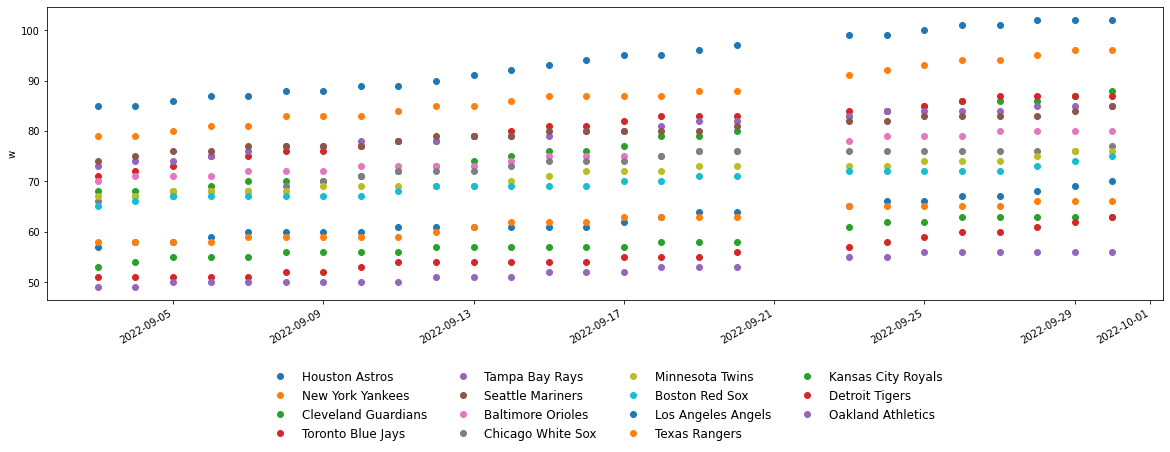

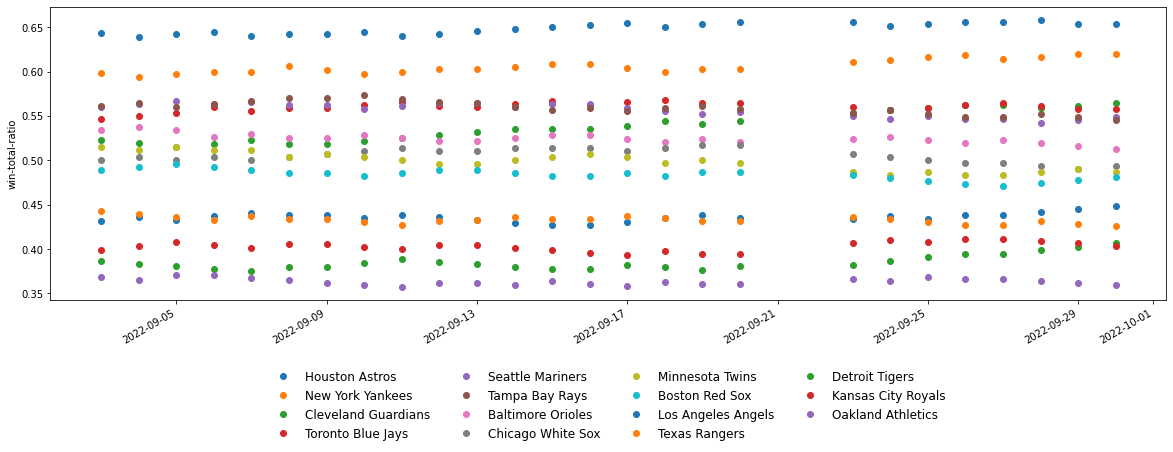

In [6]:
time_series_stats_list = ["w", "win-total-ratio"]
_, league_standings_time_series_dict = creating_time_series("league_standings", time_series_stats_list)

for stat in time_series_stats_list:
    fig, ax = plt.subplots(figsize = (20,6))
    sort_by_largest(league_standings_time_series_dict[stat]).plot(ax = ax, style= '.', linewidth = 5, markersize=12, xlabel = '', alpha = 1.0)
    ax.set_ylabel(stat)
    ax.legend(loc = "upper center", ncol = 4, fontsize = 12, bbox_to_anchor = (0.5, -0.2),  frameon = False)
    plt.show()

In [7]:
LEAGUE_NAME = 'american_league'
time_series_stats_list = ["homeRuns"]

# filter by at least 20 homers
TOTAL_NUMBER_HR = 20
N_BEST_HR_HITTERS = 10

_ , batter_time_series_dict = creating_time_series("batter_stats", time_series_stats_list)

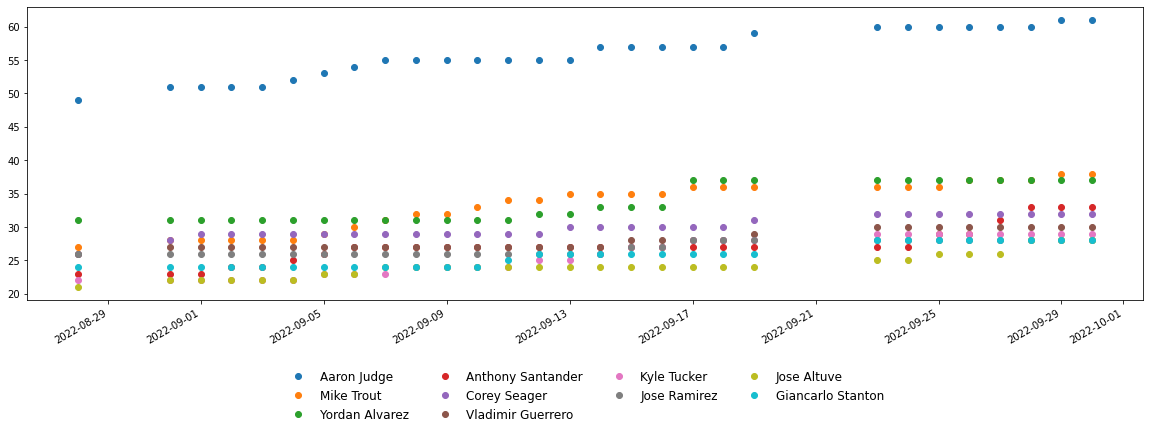

In [8]:
home_runners_df = batter_time_series_dict['homeRuns'].dropna(axis = 1)


magic_df = home_runners_df.T[home_runners_df.iloc[-1,:] > TOTAL_NUMBER_HR].T.astype(int)

fig, ax = plt.subplots(figsize = (20,6))
sort_by_largest(magic_df).iloc[:,:N_BEST_HR_HITTERS].plot(ax = ax, style= '.', linewidth = 5, markersize=12, xlabel = '', alpha = 1)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(loc = "upper center", ncol = 4, fontsize = 12, bbox_to_anchor = (0.5, -0.2),  frameon = False)
plt.show()

In [9]:
magic_df

name,Aaron Judge,Adolis Garcia,Alex Bregman,Anthony Santander,Bo Bichette,Cal Raleigh,Carlos Correa,Corey Seager,George Springer,Giancarlo Stanton,...,Matt Chapman,Mike Trout,Nathaniel Lowe,Rafael Devers,Ryan Mountcastle,Salvador Perez,Seth Brown,Vladimir Guerrero,Will Smith,Yordan Alvarez
date,,,,,,,,,,,,,,,,,,,,,
2022-08-28,49,21,19,23,17,18,15,26,18,24,...,24,27,21,25,18,17,17,26,18,31
2022-08-31,51,21,20,23,17,19,15,28,19,24,...,24,28,22,25,18,19,17,27,19,31
2022-09-01,51,21,20,23,17,19,15,29,19,24,...,24,28,22,25,18,19,17,27,19,31
2022-09-02,51,22,20,24,17,19,15,29,19,24,...,24,28,22,25,19,19,17,27,19,31
2022-09-03,51,22,20,24,18,21,15,29,19,24,...,24,28,22,25,19,19,17,27,19,31
2022-09-04,52,22,20,25,18,21,15,29,19,24,...,24,28,23,25,21,19,17,27,20,31
2022-09-05,53,22,20,26,18,22,16,29,19,24,...,24,29,23,25,21,19,19,27,21,31
2022-09-06,54,22,20,27,21,22,16,29,19,24,...,24,30,23,25,21,19,19,27,21,31
2022-09-07,55,22,20,27,22,23,16,29,19,24,...,24,31,23,25,21,20,20,27,21,31
